<a href="https://colab.research.google.com/github/sauravdas093/Kaggle_Challenge/blob/main/2)Random_Forests_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pixeltests School Data Science

*Unit 2, Sprint 2, Module 2*

---

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/pixeltests/datasets/main/' #You might not need this, use the data from Kaggle directly!
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump datset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Enter the [Kaggle](https://www.kaggle.com/t/6169ee7701164d24943c98eda2de9b5e) competition using exactly this link!
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

In [ ]:
def preprocess(df):
    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)
    df['pump_age'] = 2023 - df['construction_year']

    return df

**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/demo/train_features.csv',na_values=[0, -2.000000e-08])
labels = pd.read_csv('/content/drive/MyDrive/demo/train_labels.csv',na_values=[0, -2.000000e-08])
df['status_group']=labels['status_group'].values
X_test = pd.read_csv('/content/drive/MyDrive/demo/test_features.csv',na_values=[0, -2.000000e-08])

In [ ]:
df = preprocess(df)
X_test = preprocess(X_test)

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [ ]:
X = df.drop('status_group',axis=1)
y = labels

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, train_size=0.80, test_size=0.20,
                              stratify=df['status_group'], random_state=42)
# X_train, X_val, y_train, y_val = ..., ..., ..., ...

In [ ]:
X_train = train.drop('status_group',axis=1)
y_train = train['status_group']

In [ ]:
X_val = val.drop('status_group',axis=1)
y_val = val['status_group']

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
from sklearn.metrics import accuracy_score

majority_class = y_train.mode()[0]
y_pred= [majority_class] * len(y_train)
baseline_acc = accuracy_score(y_train, y_pred)
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5430871212121212


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


model_rf = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs=-1, bootstrap = True, oob_score =True, random_state=25)
)

In [ ]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe             3
other                          4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
other                 3
improved spring       4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, oob_score=True,
                                        random_state=25))])

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [ ]:
training_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)
print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9999736952861953
Validation Accuracy Score: 0.8013468013468014


# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`.

In [ ]:
# Use this cell to experiment and then change
# your model hyperparameters in Task 6

model_rf1 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(max_depth = 20 , n_estimators=80 , random_state=25)
)
model_rf1.fit(X_train, y_train)

training_acc1 = model_rf1.score(X_train, y_train)
val_acc1 = model_rf1.score(X_val, y_val)
print('Training Accuracy Score:', training_acc1)
print('Validation Accuracy Score:', val_acc1)

Training Accuracy Score: 0.9376315235690236
Validation Accuracy Score: 0.8016624579124579


# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

In [ ]:
y_pred = model_rf.predict(X_test)
y_pred.shape

(11880,)

In [ ]:
assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site.

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting.

In [ ]:
sample = pd.read_csv('/content/drive/MyDrive/demo/tanzania sample solution.csv')

In [ ]:
# Making Copy as accurate column as per sample submission
submission = sample[['S.No.']].copy() #get the id and the prediction
submission['status_group'] = y_pred


#Code Chunk for setting legend functional - 0, functional needs repair - 1, non functional - 2
submission['status_group1'] = submission[['status_group']]
submission = submission.set_index("status_group1")
submission.loc[['functional'], ['status_group']] = 0
submission.loc[['functional needs repair'], ['status_group']] = 1
submission.loc[['non functional'], ['status_group']] = 2
submission = submission.reset_index()
submission = submission.drop('status_group1',axis=1)
submission

#Creating final csv file for kaggle submission

submission.to_csv('Tanzania_water_pump-02.csv', index=False)

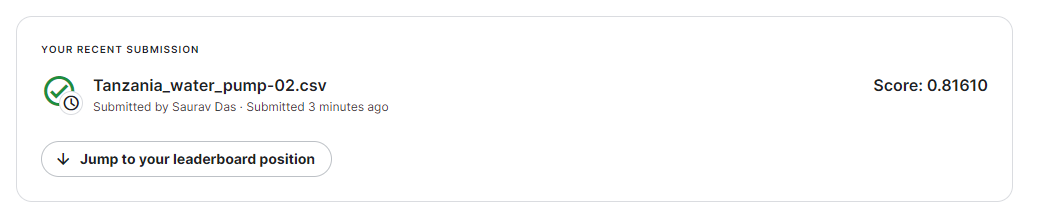

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/demo/Screenshot_random_forest_Predict-faulty-Tanzania-Water-Pumps-Kaggle (1).png')